In [3]:
!pip install thefuzz

In [4]:
!pip install python-Levenshtein

In [5]:
!pip install kneed

In [6]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from thefuzz import process, fuzz
from collections import defaultdict
from kneed import KneeLocator
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.impute import KNNImputer
from sklearn.metrics.pairwise import cosine_similarity
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import warnings
import joblib
warnings.filterwarnings('ignore')

1. Data Pre-processing

In [10]:
# Load the dataset
data = pd.read_csv('C:/Users/Owinyez/Downloads/Stock Prices Data Set.CSV')

# Display the first few rows of the dataset
data.head()

,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391


1.1 Explore the dataset

In [11]:
# check number of rows and columns
data.shape

(497472, 7)

In [12]:
# explore data types and null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497472 entries, 0 to 497471
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  497472 non-null  object 
 1   date    497472 non-null  object 
 2   open    497461 non-null  float64
 3   high    497464 non-null  float64
 4   low     497464 non-null  float64
 5   close   497472 non-null  float64
 6   volume  497472 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 26.6+ MB


In [13]:
# Check the count of symbols 
data['symbol'].nunique()

505

1.2 Data Cleaning

1.2.1 Handling Missing Values

In [14]:
# check for Missing Values
data.isnull().sum()

symbol     0
date       0
open      11
high       8
low        8
close      0
volume     0
dtype: int64

In [15]:
# Total missing values
data.isnull().sum().sum()

27

In [16]:
# Drop null values
data = data.dropna(subset=['open','high', 'low'])

# Total missing values
data.isnull().sum().sum()

0

1.2.2 Dealing with duplicates

In [17]:
# Check for duplicate rows based on all columns
print(f"Number of duplicate rows: {data.duplicated().sum()}")

Number of duplicate rows: 0


In [19]:
#sort by symbol
data_sorted = data.sort_values(by='symbol')

#show data sample
data.head()

,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391


1.2.3 Handling outliers

In [20]:
# Display datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497461 entries, 0 to 497471
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  497461 non-null  object 
 1   date    497461 non-null  object 
 2   open    497461 non-null  float64
 3   high    497461 non-null  float64
 4   low     497461 non-null  float64
 5   close   497461 non-null  float64
 6   volume  497461 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 30.4+ MB


In [23]:
#check for numerical outliers
# Z-score method
from scipy.stats import zscore
data['z_close'] = zscore(data['close'])
outliers = data[abs(data['z_close']) > 3]

data.head()

,symbol,date,open,high,low,close,volume,z_close
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943,-0.601239
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957,-0.072435
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711,0.230325
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061,-0.338899
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391,-0.162396


In [25]:
data.shape

(497461, 8)

<Axes: xlabel='close'>

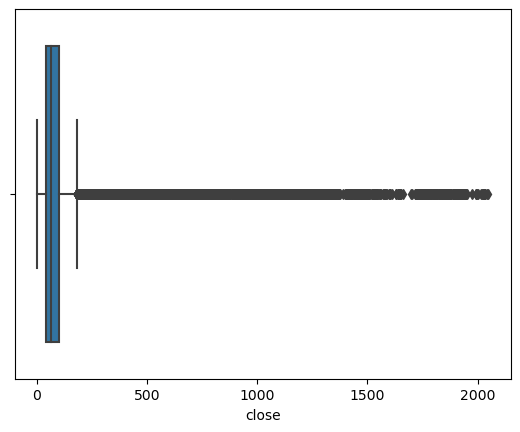

In [26]:
# visualize outliers

import seaborn as sns
sns.boxplot(x=data['close'])


NB: No outliers detected, however, I prefer to keep the z_close column for future analysis

In [29]:
data.shape

(497452, 8)

9 rows were dropped, initial minor data entry issues

2. Feature Engineering

In [31]:
#rolling averages and volatility
data['MA7'] = data.groupby('symbol')['close'].transform(lambda x: x.rolling(7).mean())
data['Volatility'] = data.groupby('symbol')['close'].transform(lambda x: x.rolling(7).std())
data['Return'] = data.groupby('symbol')['close'].pct_change()

data.head()


,symbol,date,open,high,low,close,volume,z_close,MA7,Volatility,Return
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943,-0.601239,NaN,NaN,NaN
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957,-0.072435,NaN,NaN,NaN
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711,0.230325,NaN,NaN,NaN
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061,-0.338899,NaN,NaN,NaN
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391,-0.162396,NaN,NaN,NaN


In [34]:
#feature lagging time series predictors
data['lag_1_close'] = data.groupby('symbol')['close'].shift(1)
data['lag_7_volume'] = data.groupby('symbol')['volume'].shift(7)

data.head()

,symbol,date,open,high,low,close,volume,z_close,MA7,Volatility,Return,lag_1_close,lag_7_volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943,-0.601239,NaN,NaN,NaN,NaN,NaN
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957,-0.072435,NaN,NaN,NaN,NaN,NaN
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711,0.230325,NaN,NaN,NaN,NaN,NaN
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061,-0.338899,NaN,NaN,NaN,NaN,NaN
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391,-0.162396,NaN,NaN,NaN,NaN,NaN


In [36]:
#calculate daily retuns in percentage

data['Daily_Return'] = data.groupby('symbol')['close'].pct_change()
data['Daily_Return (%)'] = data['Daily_Return'] * 100

data.head()

,symbol,date,open,high,low,close,volume,z_close,MA7,Volatility,Return,lag_1_close,lag_7_volume,Daily_Return,Daily_Return (%)
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943,-0.601239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957,-0.072435,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711,0.230325,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061,-0.338899,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391,-0.162396,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
#save the new dataset
data.to_csv('D:/Users/Owinyez/Documents/Projos/Codveda/MyData/Stock Prices Cleaned Dataset.CSV', index=False)